# **Finding exactly and all fixed points by exploiting the low-ranked formulation of shPLRNNs**
## Modified version of the CNS 2023 notebook by the Durstewitz lab!


## 1 Preliminaries: Libraries & Fetching data
The code is mainly based on Pytorch. For colab, we will download the data `lorenz-datasets.zip`, which holds training & test data as well as a pretrained model. If you are executing the notebook locally, please make sure you clone the github repository and extract the content of `lorenz-datasets.zip`.

In [1]:
import torch
import torch.nn as nn
from torch.nn.init import uniform_
from random import randint
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# load the data from the repository - only execute when using google colab
if not os.path.exists("lorenz-datasets.zip"):
  !wget https://github.com/DurstewitzLab/CNS-2023/raw/main/lorenz-datasets.zip
!unzip -o lorenz-datasets.zip
!ls

Archive:  lorenz-datasets.zip
  inflating: lorenz63_standardized_FPs.npy  
  inflating: lorenz63_test.npy       
  inflating: lorenz63_train.npy      
  inflating: pretrained-shPLRNN.pt   
CNS2023_tutorial.ipynb        lorenz63_standardized_FPs.npy
Exact_FP_shPLRNN_Lorenz.ipynb lorenz63_test.npy
README.md                     lorenz63_train.npy
fixed_points_in_shRNNs.pdf    pretrained-shPLRNN.pt
lorenz-datasets.zip


## 2 The data

The Lorenz63 system is a set of ordinary differential equations first studied by Edward Lorenz. It is notable for having chaotic solutions for certain parameter values and initial conditions. In particular, the Lorenz system is a simplified mathematical model for atmospheric convection. The system is defined by three state variables:

1. $x$ : The intensity of convective motion (or the rate of convection)
2. $y$ : The temperature difference between the ascending and descending currents
3. $z$ : The deviation of vertical temperature profile from linearity

The three coupled, first-order, nonlinear differential equations are:

1. $\frac{dx}{dt} = \sigma (y - x)$
2. $\frac{dy}{dt} = x(\rho - z) - y$
3. $\frac{dz}{dt} = xy - \beta z$

Where $\sigma$, $\rho$, and $\beta$ are parameters which represent the Prandtl number, Rayleigh number, and certain geometric factors, respectively. Here, we will use the standard parameters $\sigma=10$, $\rho=28$, and $\beta=\frac{8}{3}$. Using these settings, the Lorenz63 system exhibits multistability consisting of the famous chaotic butterfly attractor, as well as three unstable fixed points given by $\textrm{FP}_\pm = [\pm\sqrt{\beta(\rho-1)}, \pm\sqrt{\beta(\rho-1)}, \rho-1]$ inside the lobes and one at the origin. The maximum Lyapunov exponent of the chaotic attractor is $\lambda_{max} = 0.906$.

Let's load the Lorenz63 data and inspect the attractor.
The data consists of a training set and a test set. Both the train and test set are a single, long trajectory of the Lorenz63 system, started from two different, random initial conditions. The data is sampled using $\Delta t = 0.01$. In both cases, we discarded the transients such that the data only consists of the attractor. For training, we then standardize each dynamical variable to zero mean and unit variance. The training data is additionally contaminated with 5% Gaussian white noise. The data format is in $T \times N$, where $T$ is the number of available time points and $N$ is the number of dynamical variables. We assume we observe the entire system, hence $N=3$ for the Lorenz63 system. I.e. note that for simplicity, we assume that we only observed a single trajectory of the system of interest, but in principle this method can be used to learn a surrogate model from multiple trajectories.

[HINT: If you bring your own data, standardize it. Make sure your data is a numpy array/matrix of dimension $T \times N$.]

In [3]:
X_train = np.load("lorenz63_train.npy").astype(np.float32)
X_test = np.load("lorenz63_test.npy").astype(np.float32)
T_train, N = X_train.shape
T_test = X_test.shape[0]
X_train.shape, X_test.shape

((100000, 3), (100000, 3))

In [4]:
# load your external inputs here, they should be in a .npy file and of shape T x K
# S = np.load("...").astype(np.float32)

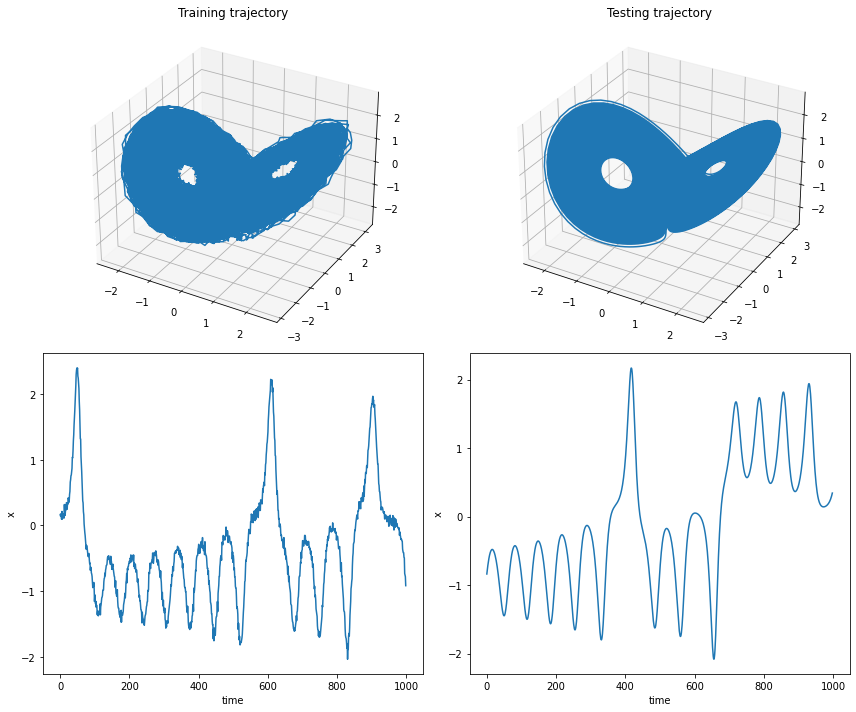

In [5]:
# visualize
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot3D(X_train[:, 0], X_train[:, 1], X_train[:, 2])
ax1.set_title('Training trajectory')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot3D(X_test[:, 0], X_test[:, 1], X_test[:, 2])
ax2.set_title('Testing trajectory')

ax3 = fig.add_subplot(223)
ax3.plot(X_train[1:1000, 0])
ax3.set_xlabel("time")
ax3.set_ylabel("x")

ax4 = fig.add_subplot(224)
ax4.plot(X_test[1:1000, 0])
ax4.set_xlabel("time")
ax4.set_ylabel("x")

plt.tight_layout()
plt.show()

## 3 The model
The model we use to reconstruct the Lorenz63 attractor is the shallowPLRNN with state equation


$$
\mathbf{z}_t = \mathbf{F}_\mathbf{\theta}(\mathbf{z}_{t-1}) = \mathbf{A}\mathbf{z}_{t-1} + \mathbf{W}_1 \textrm{ReLU}(\mathbf{W}_2\mathbf{z}_{t-1}+\mathbf{h}_2) + \mathbf{h}_1 + \mathbf{C}\mathbf{s}_t
$$


with state $\mathbf{z}_t \in \mathbb{R}^M$, external inputs $\mathbf{s}_t \in \mathbb{R}^K$ and parameters $\mathbf{A} \in \mathbb{R}^{M \times M}$ (diagonal), $\mathbf{W}_1 \in \mathbb{R}^{M \times L}$, $\mathbf{W}_2 \in \mathbb{R}^{L \times M}$, $\mathbf{h}_1 \in \mathbb{R}^M$, $\mathbf{h}_2 \in \mathbb{R}^L$, $\mathbf{C} \in \mathbb{R}^{M \times K}$ and of course $\textrm{ReLU}(\cdot) = \max(0, \cdot)$ being the rectified linear unit. The model Jacobian has an easy form, which allows straigh-forward implementation and is useful to speed up e.g. the computation of the Lyapunov spectrum.

We do not assume an additional observation model, i.e. we train the model directly on the observed data ($\mathbf{x}_t = \mathbf{I}\mathbf{z}_t = \mathbf{z}_t$).

The Lorenz63 system is autonomous, hence we omit the term $\mathbf{C}\mathbf{s}_t$ in that case. If you have a dataset with external inputs however, feel free to use it.

[HINT: If you have external inputs at your disposal, make sure there are in a $T \times K$ format].

In [6]:
class shallowPLRNN(nn.Module):
    def __init__(self, M, L, K=0):
        super(shallowPLRNN, self).__init__()
        self.M = M
        self.L = L
        self.K = K
        self.autonomous = False
        if K == 0:
            self.autonomous = True
        self.init_parameters()

    def init_parameters(self):
        r1 = 1.0 / (self.L ** 0.5)
        r2 = 1.0 / (self.M ** 0.5)
        self.W1 = nn.Parameter(uniform_(torch.empty(self.M, self.L), -r1, r1))
        self.W2 = nn.Parameter(uniform_(torch.empty(self.L, self.M), -r2, r2))
        self.A = nn.Parameter(uniform_(torch.empty(self.M), a=0.5, b=0.9))
        self.h2 = nn.Parameter(uniform_(torch.empty(self.L), -r1, r1))
        self.h1 = nn.Parameter(torch.zeros(self.M))
        if self.autonomous:
            self.C = None
        else:
            r3 = 1.0 / (self.K ** 0.5)
            self.C = nn.Parameter(uniform_(torch.empty(self.M, self.K), -r3, r3))

    def forward(self, z):
        #return self.A * z + torch.relu(z @ self.W2.T + self.h2) @ self.W1.T + self.h1
        return self.A * z + self.W1@torch.relu(self.W2@z + self.h2) + self.h1

    def jacobian(self, z):
        """Compute the Jacobian of the model at state z. Expects z to be a 1D tensor."""
        #assert z.ndim() == 1
        return torch.diag(self.A) + self.W1 @ torch.diag(self.W2 @ z > -self.h2).float() @ self.W2

    def ext_input(self, s):
        if self.autonomous or s is None:
            return 0
        elif self.autonomous and s is not None:
            raise ValueError('Model was initialized as autonomous!')
        else:
            return s @ self.C.T

    def __call__(self, z, s=None):
        """
        Compute the next state of the model. Expects `z` and `s` to be a 2D tensor
        where the first dimension is the batch dimension.
        """
        return self.forward(z) + self.ext_input(s)

@torch.no_grad()
def generate_orbit(model, z1, T, S=None):
    """
    Generate an orbit of `model`, i.e. starting from initial condition `z1`, draw
    a trajectory of length `T` with optional external input matrix `S` of shape
    `T x K`.
    """
    if S is None:
        S = [None] * T

    z = z1
    orbit = [z]
    for t in range(T):
        z = model(z, S[t])
        orbit.append(z)
    return torch.stack(orbit)


In [7]:
# load pretrained model
model = shallowPLRNN(M=3, L=50, K=0)
model.load_state_dict(torch.load("pretrained-shPLRNN.pt"))

<All keys matched successfully>

### 4 Approximately Computing Fixed Points of the Trained System

We are interested to see wheter we reconstructed the whole dynamical system including the FP's of the Lorenz63 system. For that we need to compute them. As discused before the beauty of the shallowPLRNN model is its analytical tractability which means that we have an analytical equation for calculating fixed points.

\begin{equation}
z^* = \biggl( \mathbb{1} - \bigl( A + W_1  D_{\Omega(t)} W_2)\biggl)^{-1} \biggl[W_1 D_{\Omega(t)} h_2 +h_1\biggl]
\end{equation}

where $D_{\Omega}= \text{diag} \big(d_{1}, d_{2}, \cdots, d_{L} \big)$ denotes an $L \times L$ diagonal binary indicator matrix representing the ReLU function of a specific linear subregion $\Omega$ at time step $t$ with $d_{l}=1$ if $\sum_{j=1}^{M} w^{(2)}_{lj} \,z_{j}> -h_{l}$ and $0$ otherwise.


To compute a FP we need to solve this equation for every subregion and if the solution $z^*$ lies in the same subregion $\Omega$  for which it was computed a real object has been found, otherwise we call the FP virtual.

For high-dimensional shallowPLRNNs it is not feasible to calculate this equations for every subregion $\Omega$ because of the the combinatorial explosion in their number (~$2^{dim}$). We therefore introduce an efficient search algorithm for finding all fixed points and cycles of a given shallowPLRNN, which we call $\textbf{S}$earcher for $\textbf{Cy}$cles and $\textbf{Fi}$xed points ($\textbf{SCYFI}$).

We discovered that the search becomes extremely efficient, without the need to exhaustively consider all configurations, if instead of randomly re-initializing the subregion in which we compute $z^*$ we initialize in the subregion of the last visited virtual FP.

With this simple heuristic we can efficiently calculate the dynamical objects of our shallowPLRNN.

We also have an expression for $n$-cycles:
\begin{equation}
z^{*n} =\bigg(\mathbb{1}- \prod_{i=1}^{n}\bigl( A + W_1  D_{\Omega (t^{*n}-i)} W_2\bigl) \bigg)^{-1} \times \bigg(\sum_{j=2}^{n} \Big[\prod_{i=1}^{n-j+1} \bigl( A + W_1  D_{\Omega (t^{*n}-i)} W_2\bigl) W_1 \, D_{\Omega(t^{*n}-n +j-2)} h_2 \Big]\ W_1 \,  D_{\Omega(t^{*n}-1)}  h_2
 \, + \, \Big(\sum_{j=2}^{n} \prod_{i=1}^{n-j+1} \bigl( A + W_1  D_{\Omega (t^{*n}-i)} W_2\bigl) + \mathbb{1} \Big) h_1 \bigg)
\end{equation}

but for now we will focus on computing fixed points.


Note that the paper containing this algorithm is currently under review.

In [8]:
def construct_relu_matrix(number_quadrant: int, dim: int):
    """
    Matrix describing the Relu function for different quadrants(subcompartments)
    """
    quadrant_index = format(number_quadrant, f'0{dim}b')[::-1]
    return np.diag(np.array([bool(int(bit)) for bit in quadrant_index]))

def construct_relu_matrix_list(dim: int, order: int):
    """
    Construct a list of relu matrices for a random sequence of quadrants
    """
    relu_matrix_list = np.empty((dim, dim, order))
    for i in range(order):
        n = int(np.floor(np.random.rand(1)[0] * (2 ** dim)))
        relu_matrix_list[:, :, i] = construct_relu_matrix(n, dim)
    return relu_matrix_list

def get_cycle_point_candidate(A, W1, W2, h1, h2, D_list, order):
    """
    get the candidate for a cycle point by solving the cycle equation
    """
    z_factor, h1_factor, h2_factor = get_factors(A, W1, W2, D_list, order)
    try:
        inverse_matrix = np.linalg.inv(np.eye(A.shape[0]) - z_factor)
        z_candidate = inverse_matrix.dot(h1_factor.dot(h1) + h2_factor.dot(h2))
        return z_candidate
    except np.linalg.LinAlgError:
        # Not invertible
        return None

def get_factors(A, W1, W2, D_list, order):
    """
    recursively applying map gives us the factors of the cycle equation
    """
    hidden_dim = W2.shape[0]
    latent_dim = W1.shape[0]
    factor_z = np.eye(A.shape[0])
    factor_h1 = np.eye(A.shape[0])
    factor_h2 = W1.dot(D_list[:, :, 0]).dot(np.eye(hidden_dim))
    for i in range(order - 1):
        factor_z = (A + W1.dot(D_list[:, :, i]).dot(W2)).dot(factor_z)
        factor_h1 = (A + W1.dot(D_list[:, :, i + 1]).dot(W2)).dot(factor_h1) + np.eye(A.shape[0])
        factor_h2 = (A + W1.dot(D_list[:, :, i + 1]).dot(W2)).dot(factor_h2) + W1.dot(D_list[:, :, i + 1])
    factor_z = (A + W1.dot(D_list[:, :, order-1]).dot(W2)).dot(factor_z)
    return factor_z, factor_h1, factor_h2

def get_latent_time_series(time_steps, A, W1, W2, h1, h2, dz, z_0=None):
    """
    Generate the time series by iteravely applying the PLRNN
    """
    if z_0 is None:
        z = np.random.randn(dz)
    else:
        z = z_0
    trajectory = [z]

    for t in range(1, time_steps):
        z = latent_step(z, A, W1, W2, h1, h2)
        trajectory.append(z)
    return trajectory

def latent_step(z, A, W1, W2, h1, h2):
    """
    PLRNN step
    """
    return A.dot(z) + W1.dot(np.maximum(W2.dot(z) + h2, 0)) + h1

def get_eigvals(A, W1, W2, D_list, order):
    """
    Get the eigenvalues for all the points along the trajectory to learn about the stability
    """
    e = np.eye(A.shape[0])
    for i in range(order):
        e = (np.diag(A) + W1.dot(D_list[:, :, i]).dot(W2)).dot(e)
    return np.linalg.eigvals(e)

In [9]:
def scy_fi(A, W1, W2, h1, h2, order, found_lower_orders, outer_loop_iterations=300, inner_loop_iterations=100):
    """
    heuristic algorithm for calculating FP/k-cycle
    """
    hidden_dim = h2.shape[0]
    latent_dim = h1.shape[0]
    cycles_found = []
    eigvals = []

    i = -1
    while i < outer_loop_iterations:
        i += 1
        relu_matrix_list = construct_relu_matrix_list(hidden_dim, order)
        difference_relu_matrices = 1
        c = 0
        while c < inner_loop_iterations:
            c += 1
            z_candidate = get_cycle_point_candidate(A, W1, W2, h1, h2, relu_matrix_list, order)
            if z_candidate is not None:
                trajectory = get_latent_time_series(order, A, W1, W2, h1, h2, latent_dim, z_0=z_candidate)
                trajectory_relu_matrix_list = np.empty((hidden_dim, hidden_dim, order))
                for j in range(order):
                    trajectory_relu_matrix_list[:, :, j] = np.diag((W2.dot(trajectory[j]) + h2) > 0)
                for j in range(order):
                    difference_relu_matrices = np.sum(np.abs(trajectory_relu_matrix_list[:, :, j] - relu_matrix_list[:, :, j]))
                    if difference_relu_matrices != 0:
                        break
                    if found_lower_orders:
                        if np.round(trajectory[0], decimals=2) in np.round(np.array(found_lower_orders).flatten(), decimals=2):
                            difference_relu_matrices = 1
                            break
                if difference_relu_matrices == 0:
                    if not np.any(np.isin(np.round(trajectory[0], 2), np.round(cycles_found, 2))):
                        e = get_eigvals(A, W1, W2, relu_matrix_list, order)
                        cycles_found.append(trajectory)
                        eigvals.append(e)
                        i = 0
                        c = 0
                if np.array_equal(relu_matrix_list, trajectory_relu_matrix_list):
                    relu_matrix_list = construct_relu_matrix_list(hidden_dim, order)
                else:
                    relu_matrix_list = trajectory_relu_matrix_list
            else:
                relu_matrix_list = construct_relu_matrix_list(hidden_dim, order)
    return cycles_found, eigvals

In [10]:
def main(A, W1, W2, h1, h2, order, outer_loop_iterations=None, inner_loop_iterations=None):
    found_lower_orders = []
    found_eigvals = []

    for i in range(1, order + 1):
        cycles_found, eigvals = scy_fi(A, W1, W2, h1, h2, i, found_lower_orders, outer_loop_iterations=outer_loop_iterations, inner_loop_iterations=inner_loop_iterations)

        found_lower_orders.append(cycles_found)
        found_eigvals.append(eigvals)

    return [found_lower_orders, found_eigvals]

In [11]:
A = model.A.detach().numpy()
W1 = model.W1.detach().numpy()
W2 = model.W2.detach().numpy()
h1 = model.h1.detach().numpy()
h2 = model.h2.detach().numpy()

dyn_objects, eigenvals = main(np.diag(A), W1, W2, h1, h2, 1, outer_loop_iterations=30, inner_loop_iterations=10)


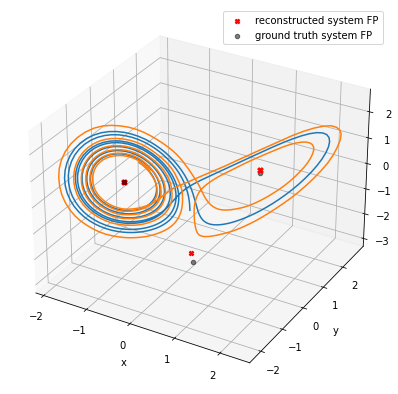

In [12]:
ax = plt.figure(figsize=(12, 7)).add_subplot(projection='3d')
t_plot = 600
# lets draw an orbit of the system
x1 = torch.tensor(X_test[0, :])
orbit = generate_orbit(model, x1, T_test).numpy()
ax.plot(X_test[:t_plot, 0], X_test[:t_plot, 1], X_test[:t_plot, 2])
ax.plot(orbit[:t_plot, 0], orbit[:t_plot, 1], orbit[:t_plot, 2])

# Scatter plot for FP
ax.scatter(dyn_objects[0][0][0][0], dyn_objects[0][0][0][1], dyn_objects[0][0][0][2],marker="X",c="red",label="reconstructed system FP")
ax.scatter(dyn_objects[0][1][0][0], dyn_objects[0][1][0][1],dyn_objects[0][1][0][2],marker="X",s=30,c="red")
ax.scatter(dyn_objects[0][2][0][0], dyn_objects[0][2][0][1], dyn_objects[0][2][0][2],marker="X",s=30,c="red")



# Scatter plot for ground truth points
true_FPs = np.load("lorenz63_standardized_FPs.npy")
ax.scatter(true_FPs[0, 0], true_FPs[1, 0], true_FPs[2, 0], c="black",label="ground truth system FP",alpha=.5)
ax.scatter(true_FPs[0, 1], true_FPs[1, 1], true_FPs[2, 1], c="black",alpha=.5)
ax.scatter(true_FPs[0, 2], true_FPs[1, 2], true_FPs[2, 2], c="black",alpha=.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()
plt.show()

In [13]:
if max(abs(eigenvals[0][0])) >1:
  print("FP 1: max eigenvalue", max(abs(eigenvals[0][0])),">1: FP is unstable")
else:
  print("FP 1: max eigenvalue", max(abs(eigenvals[0][0])),"<1: FP is stable")
if max(abs(eigenvals[0][1])) >1:
  print("FP 2: max eigenvalue", max(abs(eigenvals[0][1])),">1: FP is unstable")
else:
  print("FP 2: max eigenvalue", max(abs(eigenvals[0][1])),"<1: FP is stable")
if max(abs(eigenvals[0][2])) >1:
  print("FP 3: max eigenvalue", max(abs(eigenvals[0][2])),">1: FP is unstable")
else:
  print("FP 3: max eigenvalue", max(abs(eigenvals[0][2])),"<1: FP is stable")


FP 1: max eigenvalue 2.543892724812008 >1: FP is unstable
FP 2: max eigenvalue 2.4924737409446474 >1: FP is unstable
FP 3: max eigenvalue 2.4526270549235725 >1: FP is unstable


### 4 Exact finding of all fixed points in shPLRNN
see fixed_points_in_shRNNs.pdf in this repo

In [14]:
from itertools import combinations, chain
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s,r) for r in range(len(s)+1))

def find_fixed_points(model):
    #get parameters
    a = model.A.detach().numpy()
    V=model.W1.detach().numpy().T
    U=model.W2.detach().numpy()
    hz = model.h1.detach().numpy()
    h  = model.h2.detach().numpy()

    N=U.shape[0]
    R=U.shape[1]

    # First solve for all intersection of hyperplanes
    intersect_inds = np.array(list(combinations(np.arange(N),R)))
    n_Ds_initial = len(list(powerset(range(R))))*len(intersect_inds)
    D_list = np.zeros((n_Ds_initial,N),dtype='uint8')
    it = 0
    for inds in intersect_inds:
        b_hat = h[inds]
        U_hat = U[inds]
        z = np.linalg.solve(U_hat,-b_hat)
        
        # Find all subspaces bordering to this intersection
        x = U@z+h
        D_init = np.array(x > 0).astype('uint8')
        D_init[inds]=0
        D_list[it]=D_init
        it+=1
        D_inds = list(powerset(inds))[1:]
        for D_ind in D_inds:
            D=np.copy(D_init)
            D[np.array(D_ind)]=1
            D_list[it]=D
            it+=1


    # Throw away duplicate subspaces
    print(D_list.shape)
    D_list = np.unique(D_list,axis=0)
    print(D_list.shape)

    # Finally solve for fixed points
    z_list = []
    D_inds = []
    for D_ind,D_init in enumerate(D_list):

        A = np.eye(R)-np.diag(a)-V.T@np.diag(D_init)@U
        b = V.T@np.diag(D_init)@h+hz
        z_hat = np.linalg.solve(A,b)
        x_hat = U@z_hat+h
        if np.allclose(D_init,np.array(x_hat > 0).astype('uint8')):
            print("Found a fixed point")
            print(z_hat)
            z_list.append(z_hat)
            D_inds.append(D_ind)
    print("Done, found " + str(len(z_list)) + " fixed points")
    return D_list,D_inds,z_list
D_list,D_inds,z_list=find_fixed_points(model)

(156800, 50)
(20876, 50)
Found a fixed point
[1.16843305 1.03046877 0.49788019]
Found a fixed point
[-0.96366281 -0.85881832  0.37466785]
Found a fixed point
[ 0.07166251  0.0815779  -2.58943793]
Done, found 3 fixed points
